In [1]:
import numpy as np
from itertools import permutations, combinations
import random
import time
import sys
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import networkx as nx
import math
from IPython.display import HTML

class VisualizedDeliveryProblemSolver:
    def __init__(self, adjacency_matrix, coordinates=None):
        """
        Kh·ªüi t·∫°o v·ªõi ma tr·∫≠n k·ªÅ v√† t·ªça ƒë·ªô c√°c ƒëi·ªÉm
        adjacency_matrix: ma tr·∫≠n vu√¥ng n√ón
        coordinates: list of (x, y) tuples cho v·ªã tr√≠ c√°c ƒëi·ªÉm
        """
        self.matrix = np.array(adjacency_matrix, dtype=float)
        self.n = len(adjacency_matrix)

        # Chuy·ªÉn ƒë·ªïi 0 th√†nh infinity cho c√°c c·∫°nh kh√¥ng t·ªìn t·∫°i
        for i in range(self.n):
            for j in range(self.n):
                if i != j and self.matrix[i][j] == 0:
                    self.matrix[i][j] = np.inf
                elif i == j:
                    self.matrix[i][j] = 0

        # T·∫°o t·ªça ƒë·ªô cho c√°c ƒëi·ªÉm n·∫øu kh√¥ng ƒë∆∞·ª£c cung c·∫•p
        if coordinates is None:
            self.coordinates = self.generate_coordinates()
        else:
            self.coordinates = coordinates

    def generate_coordinates(self):
        """T·∫°o t·ªça ƒë·ªô ng·∫´u nhi√™n cho c√°c ƒëi·ªÉm"""
        coordinates = []

        # ƒêi·ªÉm 0 (kho) ·ªü trung t√¢m
        coordinates.append((50, 50))

        # C√°c ƒëi·ªÉm kh√°c ph√¢n b·ªë ng·∫´u nhi√™n
        for i in range(1, self.n):
            # T·∫°o t·ªça ƒë·ªô trong h√¨nh tr√≤n xung quanh trung t√¢m
            angle = 2 * math.pi * i / (self.n - 1)
            radius = random.uniform(20, 40)
            x = 50 + radius * math.cos(angle) + random.uniform(-5, 5)
            y = 50 + radius * math.sin(angle) + random.uniform(-5, 5)
            coordinates.append((x, y))

        return coordinates

    def print_matrix(self):
        """In ma tr·∫≠n k·ªÅ"""
        print("Ma tr·∫≠n k·ªÅ:")
        for i in range(self.n):
            row_str = ""
            for j in range(self.n):
                if self.matrix[i][j] == np.inf:
                    row_str += "‚àû".rjust(8)
                else:
                    row_str += f"{self.matrix[i][j]:.1f}".rjust(8)
            print(f"[{row_str} ]")
        print()

    def floyd_warshall(self):
        """Thu·∫≠t to√°n Floyd-Warshall"""
        dist = self.matrix.copy()

        for k in range(self.n):
            for i in range(self.n):
                for j in range(self.n):
                    if dist[i][k] + dist[k][j] < dist[i][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]

        return dist

    def is_strongly_connected(self):
        """Ki·ªÉm tra ƒë·ªì th·ªã c√≥ li√™n th√¥ng m·∫°nh kh√¥ng"""
        for start in range(self.n):
            visited = [False] * self.n
            stack = [start]
            visited[start] = True
            count = 1

            while stack:
                curr = stack.pop()
                for next_vertex in range(self.n):
                    if not visited[next_vertex] and self.matrix[curr][next_vertex] != np.inf:
                        visited[next_vertex] = True
                        stack.append(next_vertex)
                        count += 1

            if count != self.n:
                return False
        return True

    def tsp_dynamic_programming(self):
        """TSP v·ªõi Dynamic Programming"""
        if self.n > 20:
            return None, float('inf'), "S·ªë ƒëi·ªÉm qu√° l·ªõn cho DP (>20)"

        dist = self.floyd_warshall()
        dp = {}
        parent = {}

        for i in range(1, self.n):
            if dist[0][i] != np.inf:
                dp[(1 << i, i)] = dist[0][i]
                parent[(1 << i, i)] = 0

        for mask in range(1, 1 << self.n):
            for u in range(self.n):
                if not (mask & (1 << u)):
                    continue
                if (mask, u) not in dp:
                    continue

                for v in range(self.n):
                    if mask & (1 << v) or v == 0:
                        continue
                    if dist[u][v] == np.inf:
                        continue

                    new_mask = mask | (1 << v)
                    new_cost = dp[(mask, u)] + dist[u][v]

                    if (new_mask, v) not in dp or new_cost < dp[(new_mask, v)]:
                        dp[(new_mask, v)] = new_cost
                        parent[(new_mask, v)] = u

        final_mask = (1 << self.n) - 2
        min_cost = float('inf')
        last_vertex = -1

        for i in range(1, self.n):
            if (final_mask, i) in dp and dist[i][0] != np.inf:
                cost = dp[(final_mask, i)] + dist[i][0]
                if cost < min_cost:
                    min_cost = cost
                    last_vertex = i

        if last_vertex == -1:
            return None, float('inf'), "Kh√¥ng t√¨m ƒë∆∞·ª£c ƒë∆∞·ªùng ƒëi h·ª£p l·ªá"

        path = []
        mask = final_mask
        curr = last_vertex

        while (mask, curr) in parent:
            path.append(curr)
            next_curr = parent[(mask, curr)]
            mask ^= (1 << curr)
            curr = next_curr

        path.append(0)
        path = path[::-1] + [0]

        return path, min_cost, "TSP DP ho√†n th√†nh"

    def tsp_nearest_neighbor(self, start=0):
        """Thu·∫≠t to√°n Nearest Neighbor"""
        unvisited = set(range(self.n))
        current = start
        path = [current]
        total_cost = 0
        unvisited.remove(current)

        while unvisited:
            nearest = None
            min_dist = float('inf')

            for next_city in unvisited:
                if self.matrix[current][next_city] < min_dist:
                    min_dist = self.matrix[current][next_city]
                    nearest = next_city

            if nearest is None or min_dist == np.inf:
                return None, float('inf'), "Kh√¥ng t√¨m ƒë∆∞·ª£c ƒë∆∞·ªùng ƒëi h·ª£p l·ªá"

            path.append(nearest)
            total_cost += min_dist
            current = nearest
            unvisited.remove(nearest)

        if self.matrix[current][start] != np.inf:
            path.append(start)
            total_cost += self.matrix[current][start]
            return path, total_cost, "Nearest Neighbor ho√†n th√†nh"
        else:
            return None, float('inf'), "Kh√¥ng th·ªÉ quay v·ªÅ ƒëi·ªÉm ban ƒë·∫ßu"

    def tsp_2opt(self, initial_path=None, max_iterations=1000):
        """Thu·∫≠t to√°n 2-opt"""
        if initial_path is None:
            path, cost, msg = self.tsp_nearest_neighbor()
            if path is None:
                return None, float('inf'), "Kh√¥ng t√¨m ƒë∆∞·ª£c tour ban ƒë·∫ßu"
        else:
            path = initial_path[:]
            cost = self.calculate_path_cost(path)

        improved = True
        iteration = 0

        while improved and iteration < max_iterations:
            improved = False
            iteration += 1

            for i in range(1, len(path) - 2):
                for j in range(i + 1, len(path) - 1):
                    new_path = path[:i] + path[i:j+1][::-1] + path[j+1:]
                    new_cost = self.calculate_path_cost(new_path)

                    if new_cost < cost:
                        path = new_path
                        cost = new_cost
                        improved = True
                        break

                if improved:
                    break

        return path, cost, f"2-opt ho√†n th√†nh sau {iteration} v√≤ng l·∫∑p"

    def calculate_path_cost(self, path):
        """T√≠nh chi ph√≠ c·ªßa m·ªôt ƒë∆∞·ªùng ƒëi"""
        if not path or len(path) < 2:
            return float('inf')

        total_cost = 0
        for i in range(len(path) - 1):
            cost = self.matrix[path[i]][path[i + 1]]
            if cost == np.inf:
                return float('inf')
            total_cost += cost

        return total_cost

    def visualize_graph(self, path=None, title="B·∫£n ƒë·ªì giao h√†ng", save_path=None):
        """V·∫Ω ƒë·ªì th·ªã v·ªõi ƒë∆∞·ªùng ƒëi t·ªëi ∆∞u"""
        plt.figure(figsize=(12, 10))

        # V·∫Ω t·∫•t c·∫£ c√°c c·∫°nh c√≥ th·ªÉ ƒëi
        for i in range(self.n):
            for j in range(self.n):
                if i != j and self.matrix[i][j] != np.inf:
                    x1, y1 = self.coordinates[i]
                    x2, y2 = self.coordinates[j]
                    plt.plot([x1, x2], [y1, y2], 'lightgray', linewidth=0.5, alpha=0.5)

        # V·∫Ω ƒë∆∞·ªùng ƒëi t·ªëi ∆∞u n·∫øu c√≥
        if path:
            for i in range(len(path) - 1):
                x1, y1 = self.coordinates[path[i]]
                x2, y2 = self.coordinates[path[i + 1]]
                plt.plot([x1, x2], [y1, y2], 'red', linewidth=3, alpha=0.8)

                # V·∫Ω m≈©i t√™n ch·ªâ h∆∞·ªõng
                dx, dy = x2 - x1, y2 - y1
                length = math.sqrt(dx**2 + dy**2)
                if length > 0:
                    dx, dy = dx/length, dy/length
                    mid_x, mid_y = (x1 + x2)/2, (y1 + y2)/2
                    plt.arrow(mid_x - dx*2, mid_y - dy*2, dx*4, dy*4,
                             head_width=1.5, head_length=1.5, fc='red', ec='red')

        # V·∫Ω c√°c ƒëi·ªÉm
        for i, (x, y) in enumerate(self.coordinates):
            if i == 0:  # Kho h√†ng
                plt.scatter(x, y, c='green', s=200, marker='s', edgecolors='black', linewidth=2)
                plt.annotate(f'Kho {i}', (x, y), xytext=(5, 5),
                           textcoords='offset points', fontsize=10, fontweight='bold')
            else:  # ƒêi·ªÉm giao h√†ng
                plt.scatter(x, y, c='blue', s=150, marker='o', edgecolors='black', linewidth=2)
                plt.annotate(f'ƒêi·ªÉm {i}', (x, y), xytext=(5, 5),
                           textcoords='offset points', fontsize=9)

        plt.title(title, fontsize=16, fontweight='bold')
        plt.xlabel('T·ªça ƒë·ªô X', fontsize=12)
        plt.ylabel('T·ªça ƒë·ªô Y', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.axis('equal')

        # Th√™m ch√∫ th√≠ch
        legend_elements = [
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green',
                      markersize=10, label='Kho h√†ng'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                      markersize=8, label='ƒêi·ªÉm giao h√†ng'),
            plt.Line2D([0], [0], color='red', linewidth=3, label='ƒê∆∞·ªùng ƒëi t·ªëi ∆∞u'),
            plt.Line2D([0], [0], color='lightgray', linewidth=1, label='ƒê∆∞·ªùng ƒëi c√≥ th·ªÉ')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    def animate_path(self, path, title="Animation ƒë∆∞·ªùng ƒëi giao h√†ng"):
        """T·∫°o animation cho ƒë∆∞·ªùng ƒëi"""
        if not path:
            return

        fig, ax = plt.subplots(figsize=(10, 8))

        def animate(frame):
            ax.clear()

            # V·∫Ω t·∫•t c·∫£ c√°c ƒëi·ªÉm
            for i, (x, y) in enumerate(self.coordinates):
                if i == 0:
                    ax.scatter(x, y, c='green', s=200, marker='s',
                             edgecolors='black', linewidth=2)
                    ax.annotate(f'Kho {i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=10, fontweight='bold')
                else:
                    ax.scatter(x, y, c='blue', s=150, marker='o',
                             edgecolors='black', linewidth=2)
                    ax.annotate(f'ƒêi·ªÉm {i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=9)

            # V·∫Ω ƒë∆∞·ªùng ƒëi ƒë√£ ƒëi qua
            for i in range(min(frame + 1, len(path) - 1)):
                x1, y1 = self.coordinates[path[i]]
                x2, y2 = self.coordinates[path[i + 1]]
                ax.plot([x1, x2], [y1, y2], 'red', linewidth=3, alpha=0.8)

                # V·∫Ω m≈©i t√™n
                dx, dy = x2 - x1, y2 - y1
                length = math.sqrt(dx**2 + dy**2)
                if length > 0:
                    dx, dy = dx/length, dy/length
                    mid_x, mid_y = (x1 + x2)/2, (y1 + y2)/2
                    ax.arrow(mid_x - dx*2, mid_y - dy*2, dx*4, dy*4,
                            head_width=1.5, head_length=1.5, fc='red', ec='red')

            # Highlight ƒëi·ªÉm hi·ªán t·∫°i
            if frame < len(path):
                x, y = self.coordinates[path[frame]]
                ax.scatter(x, y, c='yellow', s=300, marker='*', edgecolors='red', linewidth=3)

            ax.set_title(f"{title} - B∆∞·ªõc {frame + 1}/{len(path)}", fontsize=14)
            ax.set_xlabel("T·ªça ƒë·ªô X")
            ax.set_ylabel("T·ªça ƒë·ªô Y")
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 100)
            ax.set_ylim(0, 100)
            ax.axis('equal')

        anim = FuncAnimation(fig, animate, frames=len(path),
                           interval=1000, repeat=False)
        try:
            from IPython.display import display
            display(HTML(anim.to_jshtml()))
        except:
            plt.show()

        return anim

    def compare_algorithms_visual(self):
        """So s√°nh tr·ª±c quan c√°c thu·∫≠t to√°n"""
        algorithms = []
        results = []

        # Dynamic Programming
        if self.n <= 15:
            dp_path, dp_cost, dp_msg = self.tsp_dynamic_programming()
            if dp_path:
                algorithms.append("Dynamic Programming")
                results.append((dp_path, dp_cost))

        # Nearest Neighbor
        nn_path, nn_cost, nn_msg = self.tsp_nearest_neighbor()
        if nn_path:
            algorithms.append("Nearest Neighbor")
            results.append((nn_path, nn_cost))

        # 2-opt
        if nn_path:
            opt2_path, opt2_cost, opt2_msg = self.tsp_2opt(nn_path)
            if opt2_path:
                algorithms.append("2-opt")
                results.append((opt2_path, opt2_cost))

        # V·∫Ω so s√°nh
        n_algorithms = len(algorithms)
        if n_algorithms == 0:
            return

        fig, axes = plt.subplots(1, n_algorithms, figsize=(6*n_algorithms, 6))
        if n_algorithms == 1:
            axes = [axes]

        for idx, (alg_name, (path, cost)) in enumerate(zip(algorithms, results)):
            ax = axes[idx]

            # V·∫Ω c√°c c·∫°nh c√≥ th·ªÉ
            for i in range(self.n):
                for j in range(self.n):
                    if i != j and self.matrix[i][j] != np.inf:
                        x1, y1 = self.coordinates[i]
                        x2, y2 = self.coordinates[j]
                        ax.plot([x1, x2], [y1, y2], 'lightgray', linewidth=0.5, alpha=0.3)

            # V·∫Ω ƒë∆∞·ªùng ƒëi
            for i in range(len(path) - 1):
                x1, y1 = self.coordinates[path[i]]
                x2, y2 = self.coordinates[path[i + 1]]
                ax.plot([x1, x2], [y1, y2], 'red', linewidth=2)

            # V·∫Ω c√°c ƒëi·ªÉm
            for i, (x, y) in enumerate(self.coordinates):
                if i == 0:
                    ax.scatter(x, y, c='green', s=150, marker='s', edgecolors='black')
                    ax.annotate(f'{i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=8)
                else:
                    ax.scatter(x, y, c='blue', s=100, marker='o', edgecolors='black')
                    ax.annotate(f'{i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=8)

            ax.set_title(f'{alg_name}\nChi ph√≠: {cost:.2f}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.axis('equal')

        plt.tight_layout()
        plt.show()

    def find_eulerian_cycle(self):
        """T√¨m chu tr√¨nh Euler n·∫øu t·ªìn t·∫°i (ƒë·ªì th·ªã v√¥ h∆∞·ªõng)"""
        from collections import defaultdict, Counter

        degree = [0] * self.n
        graph = defaultdict(list)

        # X√¢y d·ª±ng ƒë·ªì th·ªã v√¥ h∆∞·ªõng
        for i in range(self.n):
            for j in range(i + 1, self.n):  # Ch·ªâ duy·ªát n·ª≠a tr√™n v√¨ v√¥ h∆∞·ªõng
                if self.matrix[i][j] != np.inf:
                    graph[i].append(j)
                    graph[j].append(i)
                    degree[i] += 1
                    degree[j] += 1

        # Ki·ªÉm tra ƒëi·ªÅu ki·ªán Euler: t·∫•t c·∫£ b·∫≠c ch·∫µn
        if not all(d % 2 == 0 for d in degree):
            return None, "Kh√¥ng t·ªìn t·∫°i chu tr√¨nh Euler: c√≥ ƒë·ªânh b·∫≠c l·∫ª"

        # T·∫°o b·∫£n sao ƒë·ªì th·ªã d√πng Counter ƒë·ªÉ x·ª≠ l√Ω ƒëa c·∫°nh (n·∫øu c√≥)
        local_graph = {u: Counter(v) for u, v in graph.items()}
        path = []
        stack = [0]

        while stack:
            u = stack[-1]
            if local_graph[u]:
                v = next(iter(local_graph[u]))
                stack.append(v)

                # Gi·∫£m s·ªë l·∫ßn xu·∫•t hi·ªán (x√≥a c·∫°nh u-v v√† v-u)
                local_graph[u][v] -= 1
                if local_graph[u][v] == 0:
                    del local_graph[u][v]

                local_graph[v][u] -= 1
                if local_graph[v][u] == 0:
                    del local_graph[v][u]
            else:
                path.append(stack.pop())

        total_edges = sum(degree) // 2
        if len(path) == total_edges + 1:
            return path[::-1], "Chu tr√¨nh Euler t√¨m ƒë∆∞·ª£c th√†nh c√¥ng"
        else:
            return None, "Kh√¥ng t√¨m ƒë∆∞·ª£c chu tr√¨nh Euler ƒë·∫ßy ƒë·ªß"


    def find_hamiltonian_cycle(self):
        """T√¨m chu tr√¨nh Hamilton n·∫øu t·ªìn t·∫°i (ƒë·ªô ph·ª©c t·∫°p cao)"""
        path = [0]
        visited = [False] * self.n
        visited[0] = True

        def backtrack(pos):
            if len(path) == self.n:
                if self.matrix[path[-1]][path[0]] != np.inf:
                    path.append(0)
                    return True
                return False

            for next_node in range(1, self.n):
                if not visited[next_node] and self.matrix[pos][next_node] != np.inf:
                    path.append(next_node)
                    visited[next_node] = True
                    if backtrack(next_node):
                        return True
                    visited[next_node] = False
                    path.pop()
            return False

        if backtrack(0):
            return path, "Chu tr√¨nh Hamilton t√¨m ƒë∆∞·ª£c th√†nh c√¥ng"
        else:
            return None, "Kh√¥ng t·ªìn t·∫°i chu tr√¨nh Hamilton"

    def solve_and_visualize(self):
        """Gi·∫£i b√†i to√°n v√† t·∫°o tr·ª±c quan h√≥a"""
        print("=" * 70)
        print("GI·∫¢I B√ÄI TO√ÅN GIAO H√ÄNG V·ªöI TR·ª∞C QUAN H√ìA")
        print("=" * 70)

        self.print_matrix()
        print(f"S·ªë ƒëi·ªÉm giao h√†ng: {self.n}")
        print()

        # V·∫Ω ƒë·ªì th·ªã ban ƒë·∫ßu
        print("1. V·∫Ω b·∫£n ƒë·ªì ban ƒë·∫ßu...")
        self.visualize_graph(title="B·∫£n ƒë·ªì c√°c ƒëi·ªÉm giao h√†ng")

        # T√¨m gi·∫£i ph√°p t·ªëi ∆∞u
        best_path = None
        best_cost = float('inf')
        best_algorithm = ""

        print("2. T√¨m ƒë∆∞·ªùng ƒëi t·ªëi ∆∞u...")

        # Dynamic Programming
        if self.n <= 15:
            dp_path, dp_cost, dp_msg = self.tsp_dynamic_programming()
            print(f"Dynamic Programming: {dp_msg}")
            if dp_path and dp_cost < best_cost:
                best_path, best_cost, best_algorithm = dp_path, dp_cost, "Dynamic Programming"

        # Nearest Neighbor + 2-opt
        nn_path, nn_cost, nn_msg = self.tsp_nearest_neighbor()
        print(f"Nearest Neighbor: {nn_msg}")

        if nn_path:
            opt2_path, opt2_cost, opt2_msg = self.tsp_2opt(nn_path)
            print(f"2-opt: {opt2_msg}")

            if opt2_path and opt2_cost < best_cost:
                best_path, best_cost, best_algorithm = opt2_path, opt2_cost, "2-opt"

        # V·∫Ω k·∫øt qu·∫£
        if best_path:
            print(f"\n3. K·∫øt qu·∫£ t·ªët nh·∫•t: {best_algorithm}")
            print(f"ƒê∆∞·ªùng ƒëi: {' -> '.join(map(str, best_path))}")
            print(f"Chi ph√≠: {best_cost:.2f}")

            # V·∫Ω b·∫£n ƒë·ªì v·ªõi ƒë∆∞·ªùng ƒëi t·ªëi ∆∞u
            self.visualize_graph(best_path,
                               f"ƒê∆∞·ªùng ƒëi t·ªëi ∆∞u ({best_algorithm}) - Chi ph√≠: {best_cost:.2f}")

            # T·∫°o animation
            print("\n4. T·∫°o animation ƒë∆∞·ªùng ƒëi...")
            anim = solver.animate_path(best_path)
            HTML(anim.to_jshtml())

            # So s√°nh c√°c thu·∫≠t to√°n
            print("\n5. So s√°nh c√°c thu·∫≠t to√°n...")
            self.compare_algorithms_visual()

        # Ki·ªÉm tra chu tr√¨nh Euler
        print("\n4. Ki·ªÉm tra chu tr√¨nh Euler (v√¥ h∆∞·ªõng)...")
        euler_path, euler_msg = self.find_eulerian_cycle()
        print(f"Chu tr√¨nh Euler: {euler_msg}")
        if euler_path:
            print(" -> ".join(map(str, euler_path)))
            self.visualize_graph(euler_path, title="Chu tr√¨nh Euler")

        # Ki·ªÉm tra v√† in chu tr√¨nh Hamilton
        print("\n7. Ki·ªÉm tra chu tr√¨nh Hamilton...")
        hamilton_path, hamilton_msg = self.find_hamiltonian_cycle()
        print(f"Chu tr√¨nh Hamilton: {hamilton_msg}")
        if hamilton_path:
            print(" -> ".join(map(str, hamilton_path)))
        self.visualize_graph(hamilton_path, title="Chu tr√¨nh Hamilton")

        return best_path, best_cost, best_algorithm


def create_matrix_from_coordinates(coordinates, distance_factor=1.0):
    """T·∫°o ma tr·∫≠n kho·∫£ng c√°ch t·ª´ t·ªça ƒë·ªô"""
    n = len(coordinates)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                x1, y1 = coordinates[i]
                x2, y2 = coordinates[j]
                distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2) * distance_factor
                matrix[i][j] = distance

    return matrix.tolist()


def demo_examples_with_visualization():
    """C√°c v√≠ d·ª• demo c√≥ tr·ª±c quan h√≥a"""
    print("CH·ªåN V√ç D·ª§ DEMO V·ªöI TR·ª∞C QUAN H√ìA:")
    print("1. V√≠ d·ª• th√†nh ph·ªë nh·ªè (5 ƒëi·ªÉm)")
    print("2. V√≠ d·ª• khu v·ª±c giao h√†ng (8 ƒëi·ªÉm)")
    print("3. V√≠ d·ª• th√†nh ph·ªë l·ªõn (12 ƒëi·ªÉm)")
    print("4. T·∫°o b·∫£n ƒë·ªì ng·∫´u nhi√™n")
    print("5. Nh·∫≠p t·ªça ƒë·ªô t·ª± ƒë·ªãnh")

    choice = input("Ch·ªçn (1-5): ")

    if choice == "1":
        # V√≠ d·ª• th√†nh ph·ªë nh·ªè
        coordinates = [(50, 50), (30, 70), (70, 80), (80, 30), (20, 20)]
        matrix = create_matrix_from_coordinates(coordinates)
        print("T·∫°o b·∫£n ƒë·ªì th√†nh ph·ªë nh·ªè 5 ƒëi·ªÉm")

    elif choice == "2":
        # V√≠ d·ª• khu v·ª±c giao h√†ng
        coordinates = [
            (50, 50),   # Kho
            (30, 70), (70, 80), (80, 30), (20, 20),
            (60, 60), (40, 40), (90, 60)
        ]
        matrix = create_matrix_from_coordinates(coordinates)
        print("T·∫°o b·∫£n ƒë·ªì khu v·ª±c giao h√†ng 8 ƒëi·ªÉm")

    elif choice == "3":
        # V√≠ d·ª• th√†nh ph·ªë l·ªõn
        coordinates = [
            (50, 50),   # Kho trung t√¢m
            (20, 80), (40, 90), (60, 85), (80, 75),
            (90, 50), (85, 25), (65, 15), (35, 20),
            (15, 40), (25, 60), (75, 40)
        ]
        matrix = create_matrix_from_coordinates(coordinates)
        print("T·∫°o b·∫£n ƒë·ªì th√†nh ph·ªë l·ªõn 12 ƒëi·ªÉm")

    elif choice == "4":
        n = int(input("Nh·∫≠p s·ªë ƒëi·ªÉm (5-20): "))
        # T·∫°o t·ªça ƒë·ªô ng·∫´u nhi√™n
        coordinates = [(50, 50)]  # Kho ·ªü trung t√¢m
        for i in range(1, n):
            angle = 2 * math.pi * random.random()
            radius = random.uniform(15, 45)
            x = 50 + radius * math.cos(angle) + random.uniform(-10, 10)
            y = 50 + radius * math.sin(angle) + random.uniform(-10, 10)
            coordinates.append((x, y))

        matrix = create_matrix_from_coordinates(coordinates)
        print(f"T·∫°o b·∫£n ƒë·ªì ng·∫´u nhi√™n {n} ƒëi·ªÉm")

    else:
        n = int(input("Nh·∫≠p s·ªë ƒëi·ªÉm: "))
        coordinates = []
        print("Nh·∫≠p t·ªça ƒë·ªô c√°c ƒëi·ªÉm:")
        for i in range(n):
            x = float(input(f"T·ªça ƒë·ªô X c·ªßa ƒëi·ªÉm {i}: "))
            y = float(input(f"T·ªça ƒë·ªô Y c·ªßa ƒëi·ªÉm {i}: "))
            coordinates.append((x, y))

        matrix = create_matrix_from_coordinates(coordinates)
        print(f"T·∫°o b·∫£n ƒë·ªì t·ª´ {n} ƒëi·ªÉm t·ª± ƒë·ªãnh")

    return matrix, coordinates



ModuleNotFoundError: No module named 'networkx'

CH∆Ø∆†NG TR√åNH GI·∫¢I B√ÄI TO√ÅN GIAO H√ÄNG V·ªöI TR·ª∞C QUAN H√ìA
S·ª≠ d·ª•ng matplotlib ƒë·ªÉ v·∫Ω b·∫£n ƒë·ªì v√† animation

CH·ªåN V√ç D·ª§ DEMO V·ªöI TR·ª∞C QUAN H√ìA:
1. V√≠ d·ª• th√†nh ph·ªë nh·ªè (5 ƒëi·ªÉm)
2. V√≠ d·ª• khu v·ª±c giao h√†ng (8 ƒëi·ªÉm)
3. V√≠ d·ª• th√†nh ph·ªë l·ªõn (12 ƒëi·ªÉm)
4. T·∫°o b·∫£n ƒë·ªì ng·∫´u nhi√™n
5. Nh·∫≠p t·ªça ƒë·ªô t·ª± ƒë·ªãnh
Ch·ªçn (1-5): 1
T·∫°o b·∫£n ƒë·ªì th√†nh ph·ªë nh·ªè 5 ƒëi·ªÉm
GI·∫¢I B√ÄI TO√ÅN GIAO H√ÄNG V·ªöI TR·ª∞C QUAN H√ìA
Ma tr·∫≠n k·ªÅ:
[     0.0    28.3    36.1    36.1    42.4 ]
[    28.3     0.0    41.2    64.0    51.0 ]
[    36.1    41.2     0.0    51.0    78.1 ]
[    36.1    64.0    51.0     0.0    60.8 ]
[    42.4    51.0    78.1    60.8     0.0 ]

S·ªë ƒëi·ªÉm giao h√†ng: 5

1. V·∫Ω b·∫£n ƒë·ªì ban ƒë·∫ßu...


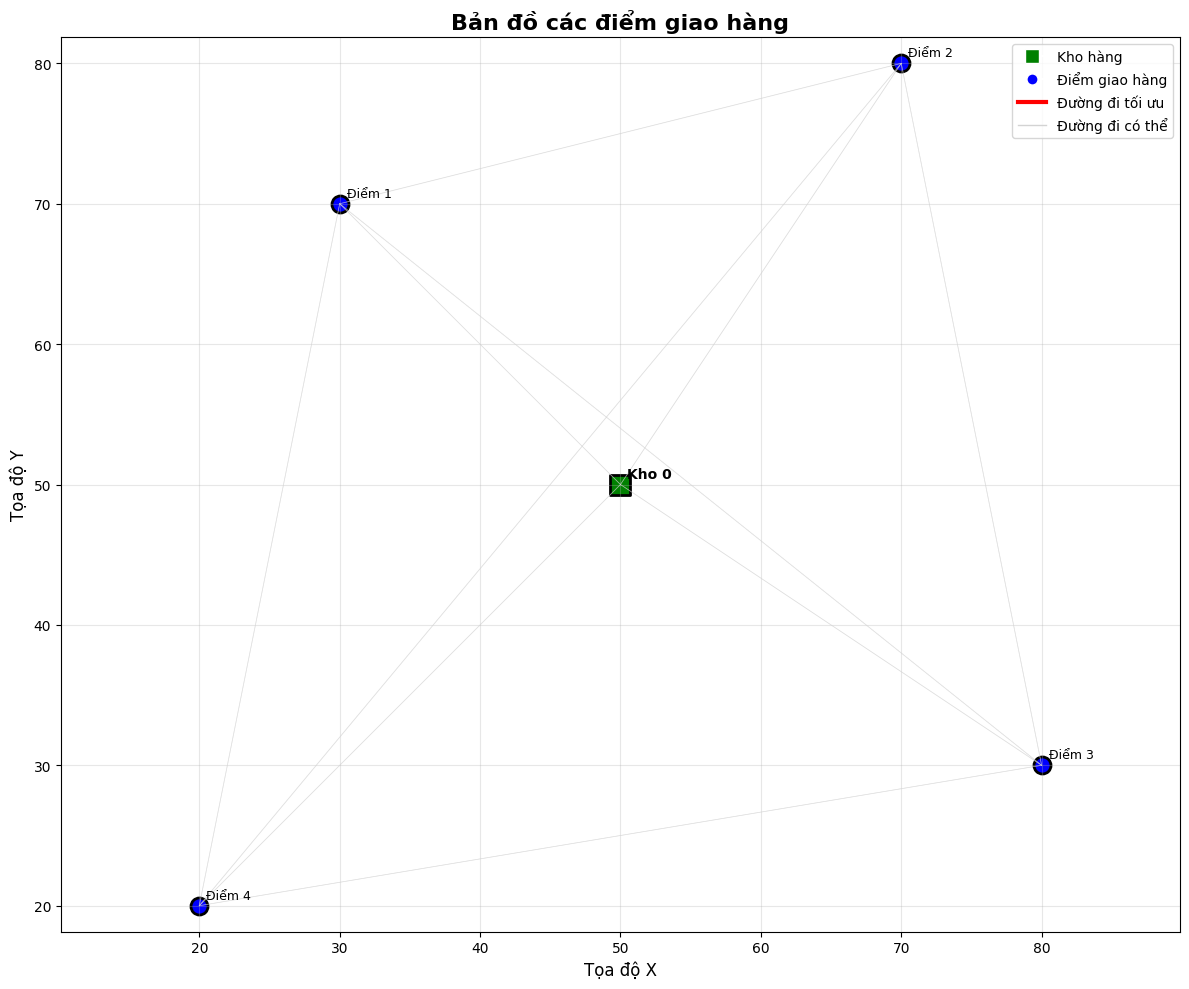

2. T√¨m ƒë∆∞·ªùng ƒëi t·ªëi ∆∞u...
Dynamic Programming: TSP DP ho√†n th√†nh
Nearest Neighbor: Nearest Neighbor ho√†n th√†nh
2-opt: 2-opt ho√†n th√†nh sau 2 v√≤ng l·∫∑p

3. K·∫øt qu·∫£ t·ªët nh·∫•t: Dynamic Programming
ƒê∆∞·ªùng ƒëi: 0 -> 4 -> 1 -> 2 -> 3 -> 0
Chi ph√≠: 221.69


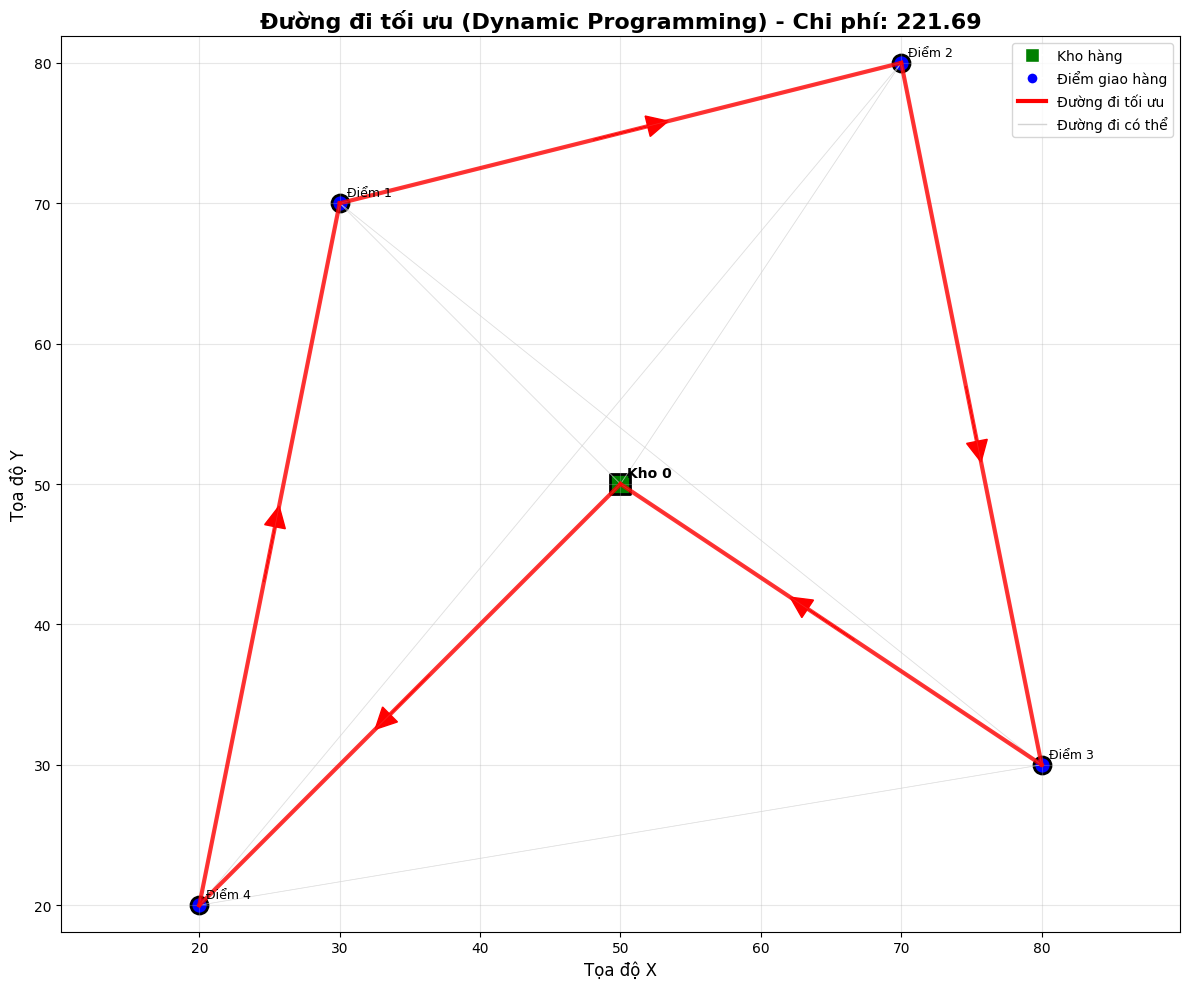


4. T·∫°o animation ƒë∆∞·ªùng ƒëi...



5. So s√°nh c√°c thu·∫≠t to√°n...


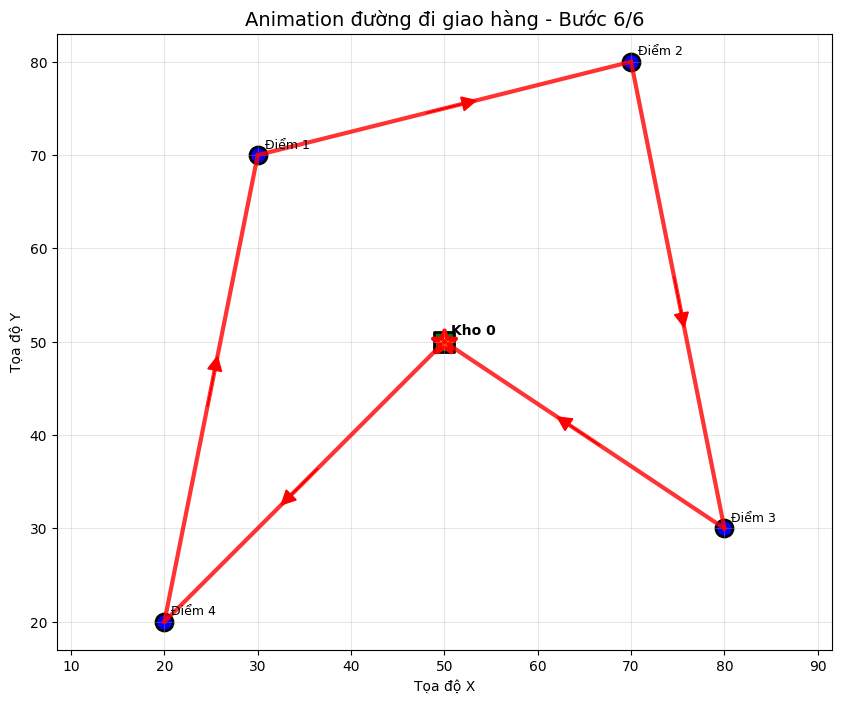

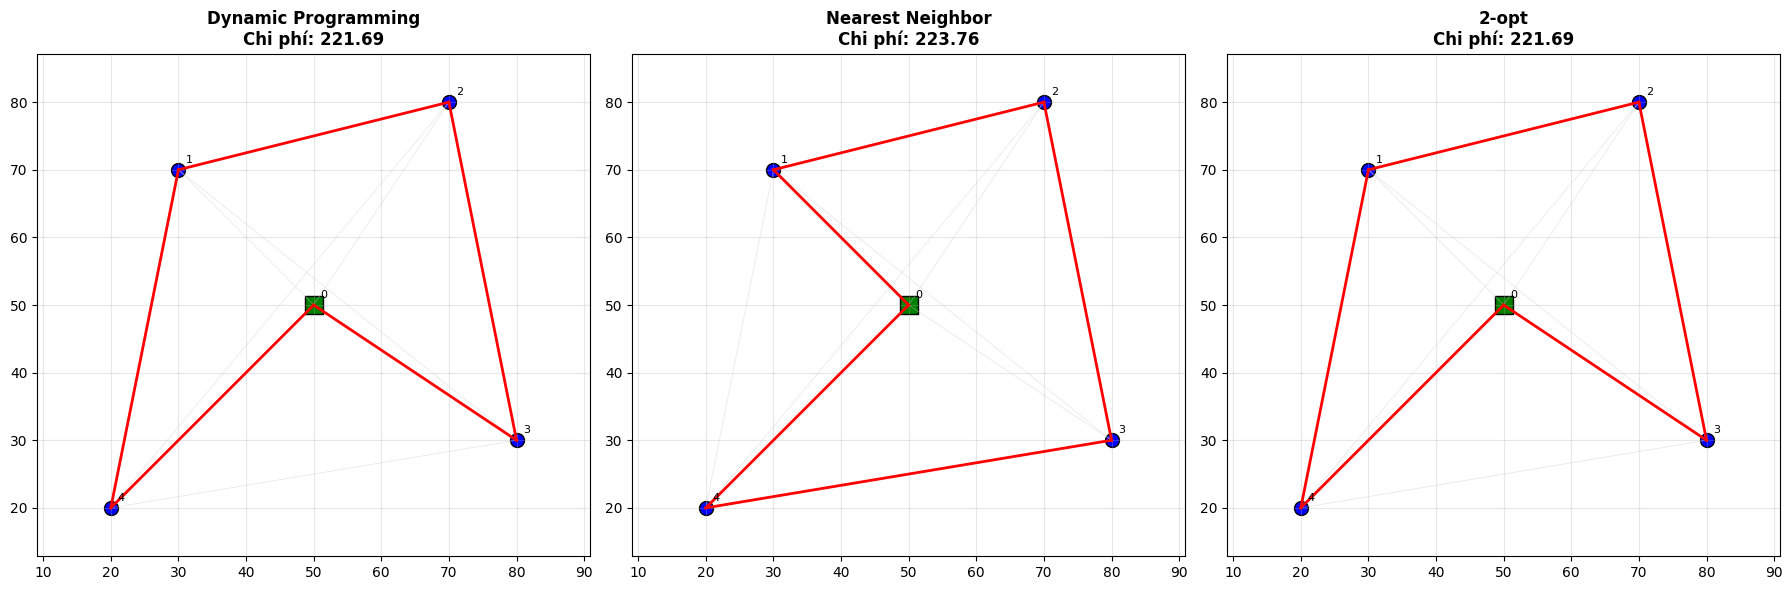


4. Ki·ªÉm tra chu tr√¨nh Euler (v√¥ h∆∞·ªõng)...
Chu tr√¨nh Euler: Chu tr√¨nh Euler t√¨m ƒë∆∞·ª£c th√†nh c√¥ng
0 -> 1 -> 2 -> 0 -> 3 -> 1 -> 4 -> 2 -> 3 -> 4 -> 0


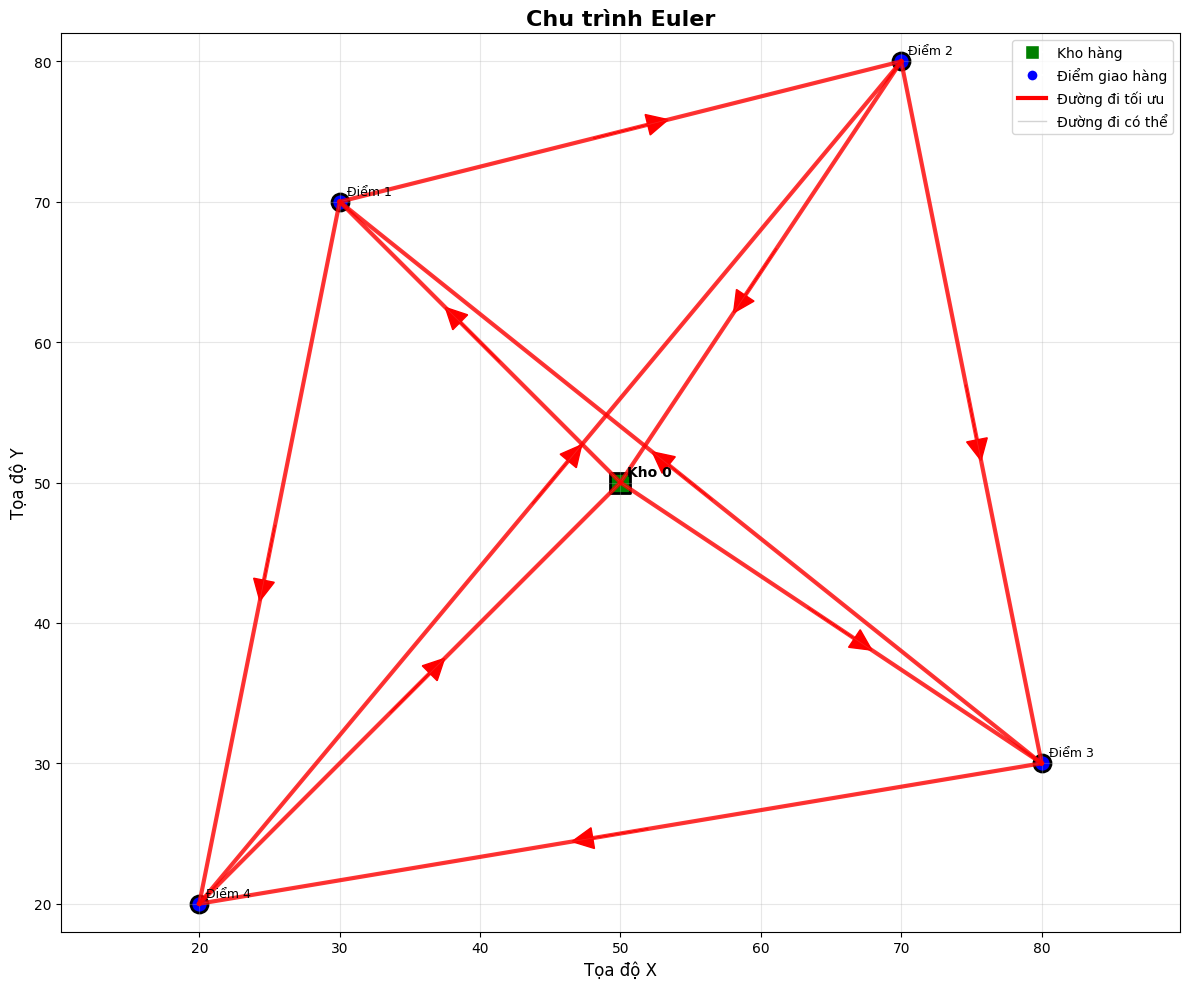


7. Ki·ªÉm tra chu tr√¨nh Hamilton...
Chu tr√¨nh Hamilton: Chu tr√¨nh Hamilton t√¨m ƒë∆∞·ª£c th√†nh c√¥ng
0 -> 1 -> 2 -> 3 -> 4 -> 0


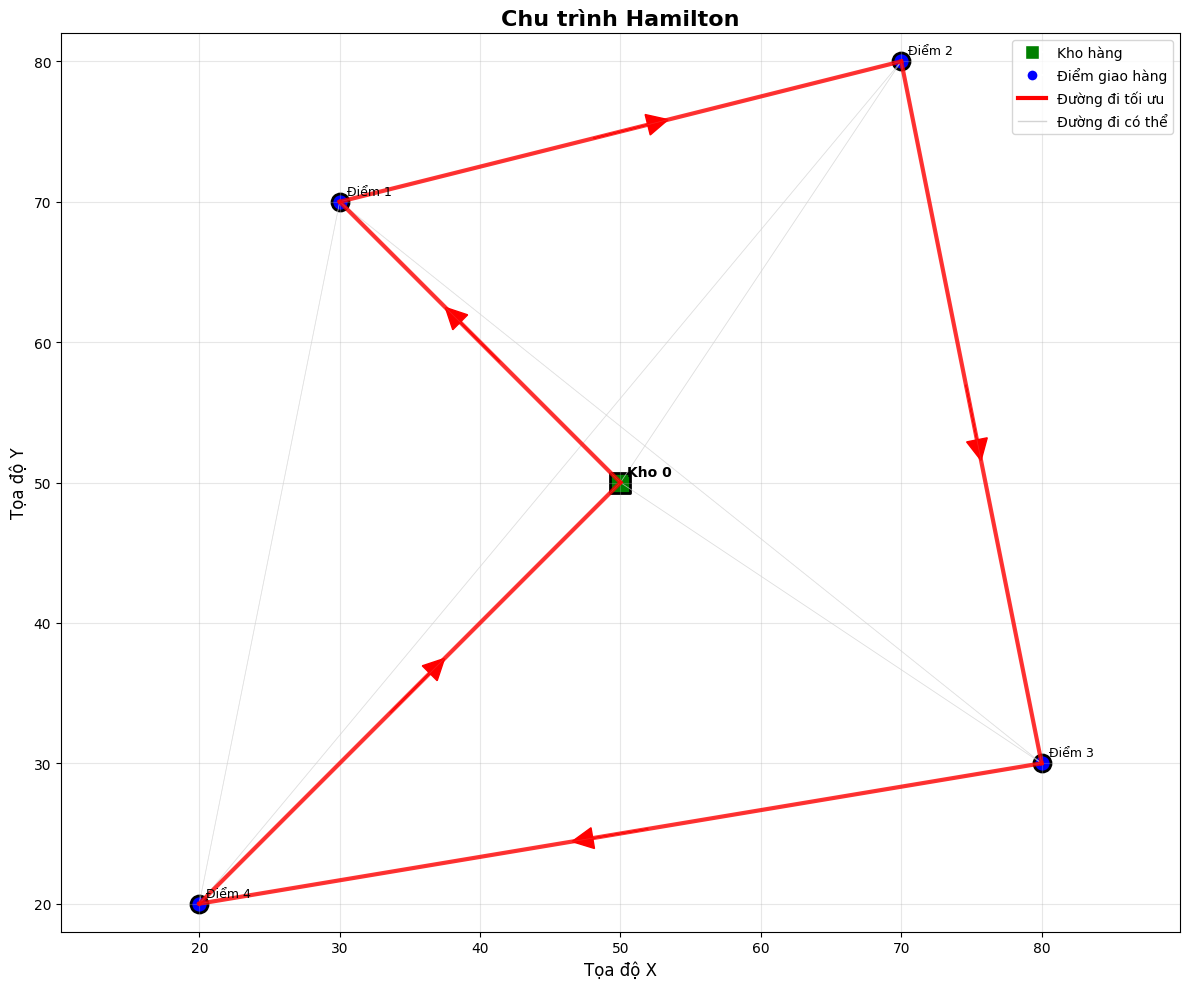


üéØ K·∫øt qu·∫£ cu·ªëi c√πng:
Thu·∫≠t to√°n t·ªët nh·∫•t: Dynamic Programming
Chi ph√≠ t·ªëi thi·ªÉu: 221.69
ƒê∆∞·ªùng ƒëi: 0 -> 4 -> 1 -> 2 -> 3 -> 0


In [ ]:
if __name__ == "__main__":
    try:
        print("CH∆Ø∆†NG TR√åNH GI·∫¢I B√ÄI TO√ÅN GIAO H√ÄNG V·ªöI TR·ª∞C QUAN H√ìA")
        print("S·ª≠ d·ª•ng matplotlib ƒë·ªÉ v·∫Ω b·∫£n ƒë·ªì v√† animation")
        print()
        38
        # L·∫•y d·ªØ li·ªáu ƒë·∫ßu v√†o
        adjacency_matrix, coordinates = demo_examples_with_visualization()

        # T·∫°o solver v√† gi·∫£i v·ªõi tr·ª±c quan
        solver = VisualizedDeliveryProblemSolver(adjacency_matrix, coordinates)
        best_path, best_cost, best_algorithm = solver.solve_and_visualize()

        print(f"\nüéØ K·∫øt qu·∫£ cu·ªëi c√πng:")
        print(f"Thu·∫≠t to√°n t·ªët nh·∫•t: {best_algorithm}")
        print(f"Chi ph√≠ t·ªëi thi·ªÉu: {best_cost:.2f}")
        print(f"ƒê∆∞·ªùng ƒëi: {' -> '.join(map(str, best_path)) if best_path else 'Kh√¥ng t√¨m ƒë∆∞·ª£c'}")

    except KeyboardInterrupt:
        print("\nCh∆∞∆°ng tr√¨nh b·ªã d·ª´ng b·ªüi ng∆∞·ªùi d√πng")
    except Exception as e:
        print(f"L·ªói: {e}")
        import traceback
        traceback.print_exc()